## 知識情報学第4回サンプルプログラム ex4.ipynb
- Programmed by Nattapong Thammasan, 監修　福井健一
- Last updated: 2021/10/26
- Checked with Python 3.8.8, scikit-learn 1.0
- MIT License

## ゴルフプレイデータのナイーブベイズ分類器による識別とROC,AUCによる評価
- データweather.nominal.arffは本プログラムと同じフォルダ内に置いておく

In [2]:
%matplotlib inline
import numpy as np
from scipy.io import arff
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_curve,roc_auc_score,auc
import matplotlib.pyplot as plt
from sklearn.naive_bayes import CategoricalNB

### arffデータの読み込み

In [3]:
f = open("weather.nominal.arff", "r", encoding="utf-8")
data, meta = arff.loadarff(f)
df_data= pd.DataFrame(data)
df_data

,outlook,temperature,humidity,windy,play
0,b'sunny',b'hot',b'high',b'FALSE',b'no'
1,b'sunny',b'hot',b'high',b'TRUE',b'no'
2,b'overcast',b'hot',b'high',b'FALSE',b'yes'
3,b'rainy',b'mild',b'high',b'FALSE',b'yes'
4,b'rainy',b'cool',b'normal',b'FALSE',b'yes'
5,b'rainy',b'cool',b'normal',b'TRUE',b'no'
6,b'overcast',b'cool',b'normal',b'TRUE',b'yes'
7,b'sunny',b'mild',b'high',b'FALSE',b'no'
8,b'sunny',b'cool',b'normal',b'FALSE',b'yes'
9,b'rainy',b'mild',b'normal',b'FALSE',b'yes'


### OrdinalEncoderを使ってラベル特徴を数値に変換
例えば，変数outlookの値{sunny, overcast, rainy}は，{0,1,2}に変換される

In [4]:
enc = OrdinalEncoder()
feature_encorded = enc.fit_transform(df_data.loc[:,['outlook','temperature', 'humidity', 'windy']])
class_encorded = np.ravel(enc.fit_transform(df_data.loc[:,['play']])) # np.ravel()で1次元化

feature_encorded, class_encorded

(array([[2., 1., 0., 0.],
        [2., 1., 0., 1.],
        [0., 1., 0., 0.],
        [1., 2., 0., 0.],
        [1., 0., 1., 0.],
        [1., 0., 1., 1.],
        [0., 0., 1., 1.],
        [2., 2., 0., 0.],
        [2., 0., 1., 0.],
        [1., 2., 1., 0.],
        [2., 2., 1., 1.],
        [0., 2., 0., 1.],
        [0., 1., 1., 0.],
        [1., 2., 0., 1.]]),
 array([0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0.]))

### 1つ抜き交差検証（Leave-one-out cross-validation）
全N個のデータから1個を除いた(N-1)個を学習データとしてモデルを学習し，残りの1個でテストを行う．これをN回繰り返す．
- 【課題2】スムージングパラメータalphaを変更してみましょう．
- 【課題3】事前確率class_priorを変更してみましょう．

In [5]:
y_train_post_list,y_train_list,y_test_post_list,y_test_list = [],[],[],[]

loo = LeaveOneOut()
for train_index, test_index in loo.split(feature_encorded):
    X_train, X_test = feature_encorded[train_index], feature_encorded[test_index]
    y_train, y_test = class_encorded[train_index], class_encorded[test_index]

    # =====================================================================
    # 課題1(a) ナイーブベイズ分類器のインスタンスを生成し，学習データに適合させる．
    # カテゴリカルナイーブベイズ（CategoricalNB）を使用する．
    # https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html
    # alpha(>0)はスムージングのパラメータ．
    # fit_prior=Trueに指定すると学習データから事前確率を求める．
    # class_priorは，class_prior=[0.2,0.8]の形で事前確率を指定する．fit_prior=Falseのときに有効．
    
    nb_classifier = CategoricalNB(alpha=1, fit_prior=True)
    nb_classifier.fit(X_train, y_train)

    # =====================================================================
    # 課題1(b) 学習データとテストデータに対する各クラスの事後確率を算出
    # 学習データとテストデータに対する各クラスの事後確率を算出
    posterior_trn = nb_classifier.predict_proba(X_train)
    posterior_tst = nb_classifier.predict_proba(X_test)

    # テストデータの正解クラスと事後確率を出力
    print("True Label:", y_test)
    print("Posterior Probability:", posterior_tst)

    # 正解クラスと事後確率を保存
    y_train_post_list.extend(posterior_trn[:,[1]])
    y_train_list.extend(y_train)
    y_test_post_list.append(posterior_tst[0][1])
    y_test_list.extend(y_test)

True Label: [0.]
Posterior Probability: [[0.45539547 0.54460453]]
True Label: [0.]
Posterior Probability: [[0.68701207 0.31298793]]
True Label: [1.]
Posterior Probability: [[0.42974366 0.57025634]]
True Label: [1.]
Posterior Probability: [[0.60114784 0.39885216]]
True Label: [1.]
Posterior Probability: [[0.21132271 0.78867729]]
True Label: [0.]
Posterior Probability: [[0.05553006 0.94446994]]
True Label: [1.]
Posterior Probability: [[0.15155766 0.84844234]]
True Label: [0.]
Posterior Probability: [[0.33409552 0.66590448]]
True Label: [1.]
Posterior Probability: [[0.34891232 0.65108768]]
True Label: [1.]
Posterior Probability: [[0.23161973 0.76838027]]
True Label: [1.]
Posterior Probability: [[0.61651653 0.38348347]]
True Label: [1.]
Posterior Probability: [[0.50119624 0.49880376]]
True Label: [1.]
Posterior Probability: [[0.13097846 0.86902154]]
True Label: [0.]
Posterior Probability: [[0.39704676 0.60295324]]


### ROC曲線の描画とAUCの算出
- roc_curve
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
- roc_auc_score
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
- auc
    - 関数roc_auc_scoreの代わりに関数aucを使用してもよい
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc

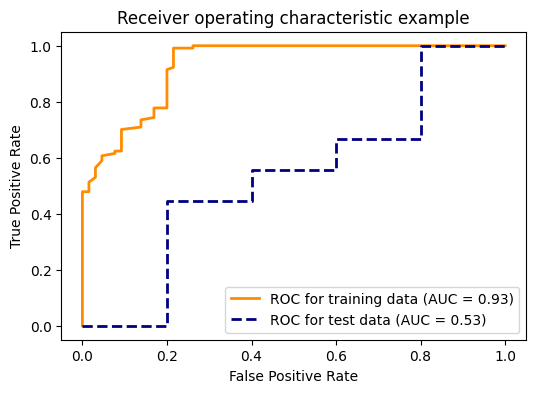

In [6]:
# 課題1(c) 学習データおよびテストデータに対するROC曲線の描画とAUCを算出する

fpr_train, tpr_train, _ = roc_curve(y_train_list, y_train_post_list)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, _ = roc_curve(y_test_list, y_test_post_list)
roc_auc_test = auc(fpr_test, tpr_test)


plt.figure(figsize=(6, 4))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'ROC for training data (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='navy', lw=2, linestyle='--', label=f'ROC for test data (AUC = {roc_auc_test:.2f})')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.show()

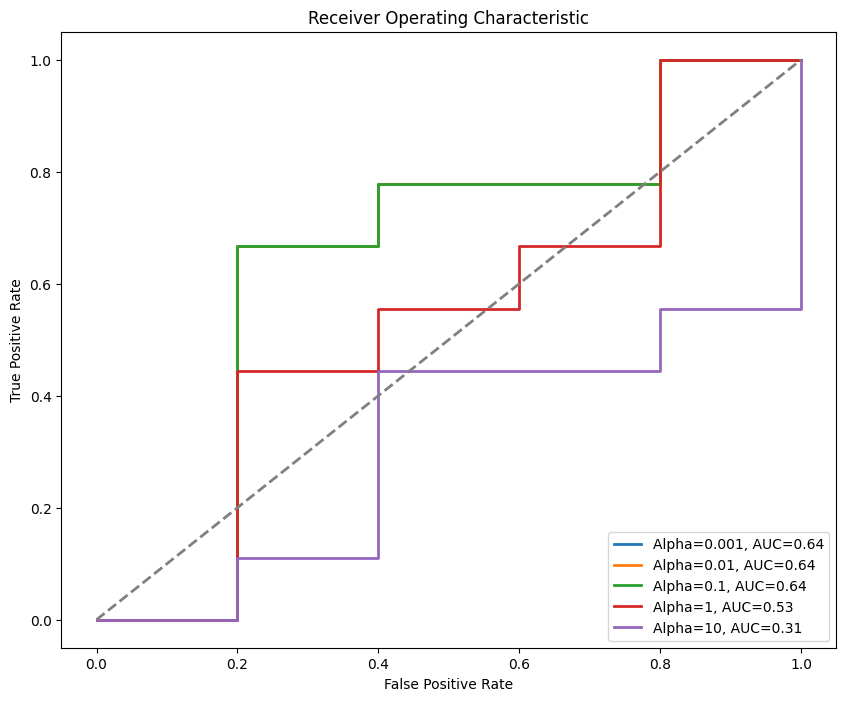

In [7]:
alphas = [0.001, 0.01, 0.1, 1, 10]

plt.figure(figsize=(10, 8))

for alpha in alphas:
    y_train_post_list, y_train_list, y_test_post_list, y_test_list = [], [], [], []
    
    loo = LeaveOneOut()
    for train_index, test_index in loo.split(feature_encorded):
        X_train, X_test = feature_encorded[train_index], feature_encorded[test_index]
        y_train, y_test = class_encorded[train_index], class_encorded[test_index]

        nb_classifier = CategoricalNB(alpha=alpha, fit_prior=True)
        nb_classifier.fit(X_train, y_train)

        posterior_trn = nb_classifier.predict_proba(X_train)
        posterior_tst = nb_classifier.predict_proba(X_test)

        y_train_post_list.extend(posterior_trn[:, 1])
        y_train_list.extend(y_train)
        y_test_post_list.append(posterior_tst[0, 1])
        y_test_list.extend(y_test)

    fpr, tpr, _ = roc_curve(y_test_list, y_test_post_list)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'Alpha={alpha}, AUC={roc_auc:.2f}')

# プロット設定
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# グラフの表示
plt.show()


αの値を大きくすると、スムージングが強化されたため、モデルが単純化し、AUCの値が低くなったと考えられる。\
αの値を小さくしても、AUCの値に変化が見られなかった。これは既にうまくモデル化されており、スムージングの必要性が低かったからであると考えられる。

## 課題4-3. 事前確率(fit_prior, class_prior)を変更し，ROC曲線，AUCおよび事後確率の値について，何故そのような挙動をするのか 考察しなさい．（2点）

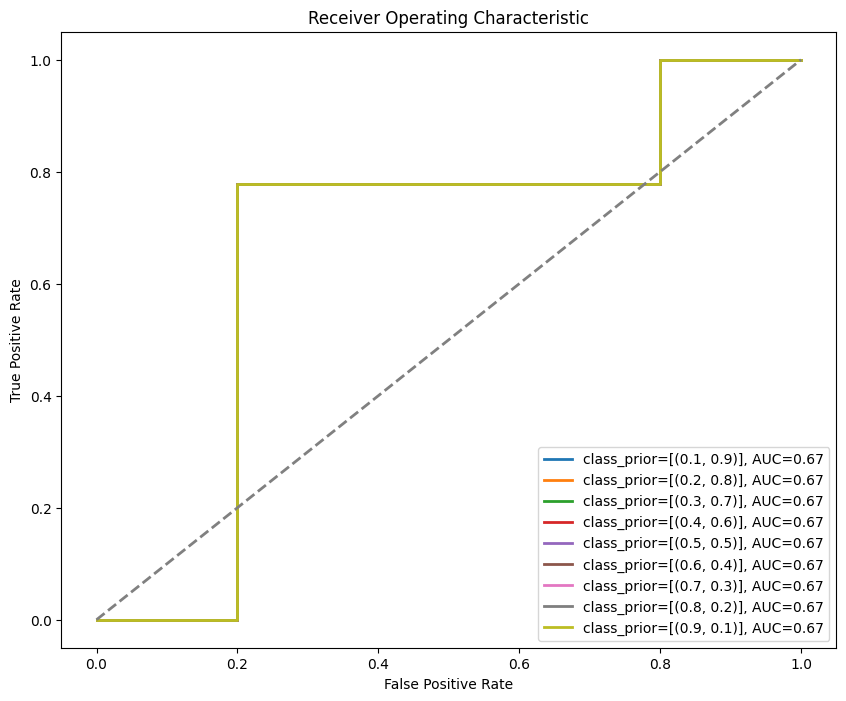

In [9]:
class_priors = [1, 2, 3, 4, 5,6,7,8,9]

plt.figure(figsize=(10, 8))

for class_prior in class_priors:
    y_train_post_list, y_train_list, y_test_post_list, y_test_list = [], [], [], []
    
    loo = LeaveOneOut()
    for train_index, test_index in loo.split(feature_encorded):
        X_train, X_test = feature_encorded[train_index], feature_encorded[test_index]
        y_train, y_test = class_encorded[train_index], class_encorded[test_index]

        nb_classifier = CategoricalNB(alpha=0.1, fit_prior=False, class_prior=[class_prior/10 , (10-class_prior)/10])
        nb_classifier.fit(X_train, y_train)

        posterior_trn = nb_classifier.predict_proba(X_train)
        posterior_tst = nb_classifier.predict_proba(X_test)

        y_train_post_list.extend(posterior_trn[:, 1])
        y_train_list.extend(y_train)
        y_test_post_list.append(posterior_tst[0, 1])
        y_test_list.extend(y_test)

    fpr, tpr, _ = roc_curve(y_test_list, y_test_post_list)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f'class_prior=[{class_prior/10 , (10-class_prior)/10}], AUC={roc_auc:.2f}')

# プロット設定
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# グラフの表示
plt.show()


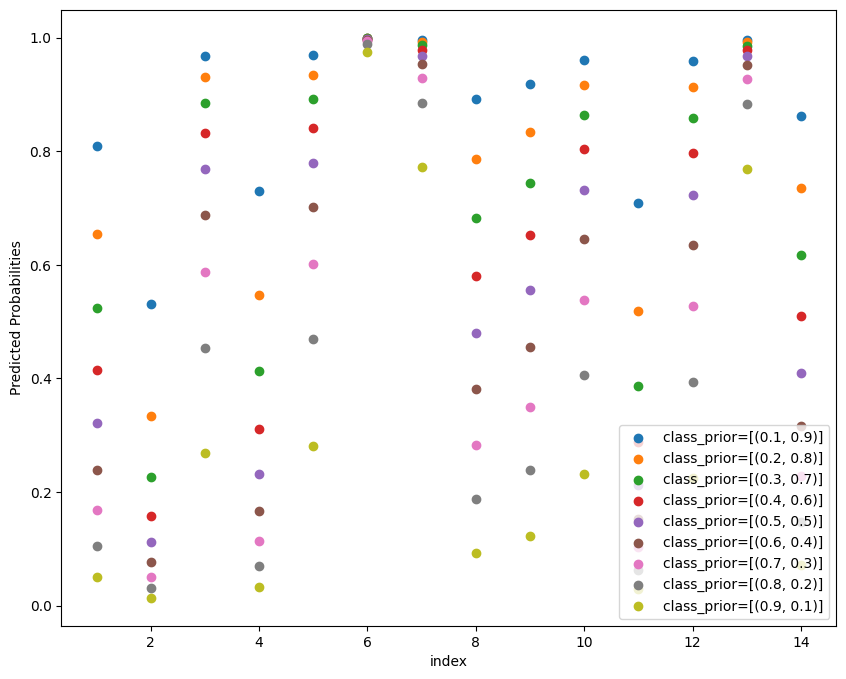

In [27]:
class_priors = range(1, 10)

plt.figure(figsize=(10, 8))

for class_prior in class_priors:
    y_train_post_list, y_train_list, y_test_post_list, y_test_list = [], [], [], []

    loo = LeaveOneOut()
    for train_index, test_index in loo.split(feature_encorded):
        X_train, X_test = feature_encorded[train_index], feature_encorded[test_index]
        y_train, y_test = class_encorded[train_index], class_encorded[test_index]

        nb_classifier = CategoricalNB(alpha=0.1, fit_prior=False, class_prior=[class_prior/10 , (10-class_prior)/10])
        nb_classifier.fit(X_train, y_train)

        posterior_trn = nb_classifier.predict_proba(X_train)
        posterior_tst = nb_classifier.predict_proba(X_test)

        y_train_post_list.extend(posterior_trn[:, 1])
        y_train_list.extend(y_train)
        y_test_post_list.append(posterior_tst[0, 1])
        y_test_list.extend(y_test)
        
    plt.scatter(range(1,15), y_test_post_list, label=f'class_prior=[{class_prior/10 , (10-class_prior)/10}]')  # c=y_test_listでクラスごとに色分け

    
plt.xlabel('index')
plt.ylabel('Predicted Probabilities')    
plt.legend(loc="lower right")
plt.show()


事前確率を変更してもAUCが同じであるため、モデルの区別能力が事前確率の変動に影響を受けていないと考えられる。\
散布図から、インデックスごとに様々な予測確率が得られており、クラスの事前確率によって予測が大きく変わっていることが分かる。\
しかし、ランキング順序は変わっておらず、そのため、AUCの値も変化しなかったと考えられる。